# Financial inclusion in Kenya, Tanzania, Rwanda and Uganda
Group 4: Flo, Markus and Jan

In [117]:
# Load packages
# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
#from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [118]:
# Load data
df = pd.read_csv('Train.csv')

# EDA

EDA was partly done in the StarterNotebook and more extensively [here](https://medium.com/analytics-vidhya/why-you-need-to-explore-your-data-how-you-can-start-13de6f29c8c1) and also in the downloadable file at the end of the article.

Keypoints: No NaNs, most features are categorical, target is unbalanced (85-15). Not much cleaning is needed

Influence of categorical features on target:

In [119]:
ctdf = df.select_dtypes(include='object').drop(["bank_account","uniqueid"], axis=1)
ctdf_y = df.bank_account


for column_name in ctdf.columns:
    print(pd.crosstab(ctdf[column_name], ctdf_y,normalize="index"))
    print("____________")


bank_account        No       Yes
country                         
Kenya         0.749341  0.250659
Rwanda        0.885175  0.114825
Tanzania      0.908308  0.091692
Uganda        0.913851  0.086149
____________
bank_account         No       Yes
location_type                    
Rural          0.883497  0.116503
Urban          0.821261  0.178739
____________
bank_account            No       Yes
cellphone_access                    
No                0.982867  0.017133
Yes               0.816203  0.183797
____________
bank_account                No       Yes
gender_of_respondent                    
Female                0.893205  0.106795
Male                  0.810304  0.189696
____________
bank_account                  No       Yes
relationship_with_head                    
Child                   0.913414  0.086586
Head of Household       0.822851  0.177149
Other non-relatives     0.894737  0.105263
Other relative          0.901198  0.098802
Parent                  0.940147  0.059853
S

In [120]:
pd.crosstab(ctdf.country, ctdf.cellphone_access, normalize="index")

cellphone_access,No,Yes
country,,
Kenya,0.211437,0.788563
Rwanda,0.170120,0.829880
Tanzania,0.402417,0.597583
Uganda,0.303189,0.696811


Keypoints:  
People without a cellphone are very unlikely to have a bank account.    
Differences among countries. 25% of people in Kenya have a bank account and only 8-11% of people in Rwanda, Uganda and Tanzania. 
Differences between rural and urban and between genders are present but not as prominent as expected.  
Education level and job type have big differences between the bank account proportions.


# Feature engineering

We utilized different ways to treat the features like Min-Max scaling of the numerical features, random under and oversampling of the unbalanced target, using drop_first = T dummies for the categorical variables. However, we obtained the best score without those transformations. We are still applying min-max scaling to make the features comparable, because we want to identify the important features for our stakeholder.  
Additionally, we are getting rid of the 'year' column because not all countries have been sampled in all years. There is an increased number of bank_accounts in 2018, however, this is due to the fact that Kenya was only sampled in that year.

In [121]:
# Convert all non-binary categories to k categories
cats = ["country", "relationship_with_head", "marital_status", "education_level", "job_type"] 
df_dumm2 = pd.get_dummies(df, prefix_sep="_", columns = cats)

# Convert all binary categories to k-1 categories
bin_cat = ["bank_account", "location_type", "cellphone_access","gender_of_respondent"]
df_dumm2 = pd.get_dummies(df_dumm2, prefix_sep="_", columns = bin_cat, drop_first=True)
# Drop 'uniqueid'
df_dumm2.drop("uniqueid",inplace=True, axis= 1)

df_dumm2.head()

,year,household_size,age_of_respondent,country_Kenya,country_Rwanda,country_Tanzania,country_Uganda,relationship_with_head_Child,relationship_with_head_Head of Household,relationship_with_head_Other non-relatives,...,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed,bank_account_Yes,location_type_Urban,cellphone_access_Yes,gender_of_respondent_Male
0,2018,3,24,True,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,True,False
1,2018,5,70,True,False,False,False,False,True,False,...,True,False,False,False,False,False,False,False,False,False
2,2018,5,26,True,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,True,True
3,2018,5,34,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
4,2018,8,26,True,False,False,False,True,False,False,...,False,True,False,False,False,False,False,True,False,True


In [122]:
# Train-Test-Split
y2 = df_dumm2[["bank_account_Yes"]]
X2 = df_dumm2.drop(["bank_account_Yes","year"], axis = 1)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2, y2, random_state=42, stratify=y2) # Default 25% in test

In [123]:
# # Min-Max-Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modelling

Baseline Model: Our baseline model is based on the basic assumption that people living in rural areas and with just basic education do not own a bank account.

In [124]:
y_pred_baseline = []

X_test_scaled_df = pd.DataFrame(X_test,columns = df_dumm2.drop(["bank_account_Yes","year"],axis=1).columns)

for index, row in X_test_scaled_df.iterrows():
    if row["location_type_Urban"] or row['education_level_Other/Dont know/RTA'] or row['education_level_Secondary education'] or row['education_level_Tertiary education'] or row[ 'education_level_Vocational/Specialised training']:
        y_pred_baseline.append(1)
    else:
        y_pred_baseline.append(0)
print(confusion_matrix(y_test,y_pred_baseline))
print(accuracy_score(y_test, y_pred_baseline))

[[2574 2479]
 [ 176  652]]
0.5485461656180921


The baseline model is bad in predicting if a person owns a bank account or not. The accuracy is only 55% and there are a lot of false positives indicating that many people living in rural areas and with early education own a bank account. Those two features alone don't predict the target very well.

## Classification by logistic regression.  
Our best model - determined by a GridSearch - reaches an accuracy of 88.6%

In [125]:
logmod = LogisticRegression(max_iter=1000, solver="liblinear", fit_intercept=True, class_weight = None, C=2)
logmod.fit(X_train, y_train)

y_pred = logmod.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))


[[4919  134]
 [ 537  291]]
              precision    recall  f1-score   support

       False       0.90      0.97      0.94      5053
        True       0.68      0.35      0.46       828

    accuracy                           0.89      5881
   macro avg       0.79      0.66      0.70      5881
weighted avg       0.87      0.89      0.87      5881

0.8859037578643087


/Users/janschlautmann/neuefische/ds-ml-financial-inclusion-project/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Parameter estimates

In [126]:
coef_df = pd.DataFrame({"cols": X2.columns, "coefs": logmod.coef_[0]})
coef_df

,cols,coefs
0,household_size,0.111871
1,age_of_respondent,1.193706
2,country_Kenya,0.229407
3,country_Rwanda,-0.122471
4,country_Tanzania,-0.953775
5,country_Uganda,-1.117130
6,relationship_with_head_Child,-0.539563
7,relationship_with_head_Head of Household,0.203465
8,relationship_with_head_Other non-relatives,-0.576723
9,relationship_with_head_Other relative,-0.481133


As expected from the crosstab in the EDA section the highest influence seems to be the cellphone_access, job_type, education_level, country, and also the age. There are also differences between certain levels in the marital_status and relationship_with_head features.

In [127]:
pd.crosstab( df.country,df.cellphone_access , normalize="index")

cellphone_access,No,Yes
country,,
Kenya,0.211437,0.788563
Rwanda,0.170120,0.829880
Tanzania,0.402417,0.597583
Uganda,0.303189,0.696811


# Error analysis

Are there certain category levels which are predicted better/worse? Using the whole data set.

In [128]:
y2 = df_dumm2[["bank_account_Yes"]]
X2 = df_dumm2.drop(["bank_account_Yes","year"], axis = 1)
X3 = scaler.fit_transform(X2)

logmod_full = LogisticRegression(max_iter=1000, solver="liblinear", fit_intercept=True, class_weight = None, C=2)
logmod_full.fit(X3, y2.values.ravel())

y_pred_full = logmod_full.predict(X3) # Accuracy of 88.53

print(accuracy_score(y2, y_pred_full))



0.8854361503145723


In [129]:
ea_data = df

ea_data["bank_pred"] = y_pred_full                                                  # Predictions from the model
ea_data["bank_account"] = ea_data.bank_account.replace({'Yes': 1, 'No': 0})         # Convert Yes/No to 1/0
ea_data["bank_correct"] = ea_data["bank_account"] == ea_data["bank_pred"]           # Checks if the prediction is correct. False are the false positives and false negatives.
ea_data["bank_correct"] = ea_data["bank_correct"].astype(int)

prop_df = pd.DataFrame(columns=["cat", "prop_correct"])
for cat in ["country", "relationship_with_head", "marital_status", "education_level", "job_type", "location_type", "cellphone_access","gender_of_respondent"]:
    #print(ea_data.groupby(cat)["bank_correct"].mean().reset_index())
    #print("_________")
    test_df = ea_data.groupby(cat)["bank_correct"].mean().reset_index()
    test_df.columns = ["cat", "prop_correct"]
    prop_df = pd.concat([prop_df,test_df],axis=0,ignore_index=True)

prop_df.sort_values("prop_correct")

,cat,prop_correct
20,Vocational/Specialised training,0.679950
24,Formally employed Private,0.710900
19,Tertiary education,0.747623
18,Secondary education,0.794459
23,Formally employed Government,0.803618
0,Kenya,0.809328
25,Government Dependent,0.809717
36,Male,0.850213
34,Yes,0.851381
28,Other Income,0.855556


In [130]:
# Nice plots

# maybe map to show country differences
# unbalanced data -> 85% without bank account

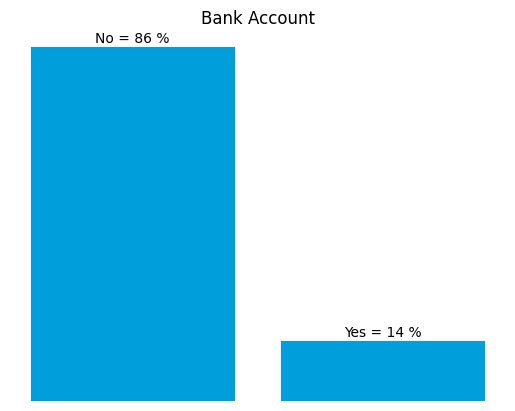

In [198]:
# value_counts = df['bank_account'].value_counts(normalize=True)
# value_counts = value_counts.sort_values(ascending=False)
# bars = plt.bar(value_counts.index, value_counts.values, color = ["#009EDB", "white"], edgecolor = ["#009EDB", "#009EDB"], linewidth = 3)
# plt.xlabel('')
# plt.ylabel('')
# plt.title('Bank Account', weight="bold")
# plt.axis("off")
# plt.xticks(rotation=90)  # Rotate x-axis labels if needed
# ax = plt.gca()
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['right'].set_visible(False)

# text = ["Yes = 86 %", "No = 14 %"]

# for i,bar in enumerate(bars):
#     height = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width() / 2, height+0.01, text[i], ha='center', va='bottom', weight="bold")


# plt.show()


value_counts = df['bank_account'].value_counts(normalize=True)
value_counts = value_counts.sort_values(ascending=False)
bars = plt.bar(value_counts.index, value_counts.values, color = ["#009EDB", "#009EDB"], edgecolor = ["#009EDB", "#009EDB"], linewidth = 3)
plt.xlabel('')
plt.ylabel('')
plt.title('Bank Account')
plt.axis("off")
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
ax = plt.gca()
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['right'].set_visible(False)



text = ["No = 86 %", "Yes = 14 %"]
for i,bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, text[i], ha='center', va='bottom')

plt.show()

In [94]:
cellphone_props = pd.crosstab(ctdf.cellphone_access,ctdf_y, normalize="index")
cellphone_props


bank_account,No,Yes
cellphone_access,,
No,0.982867,0.017133
Yes,0.816203,0.183797


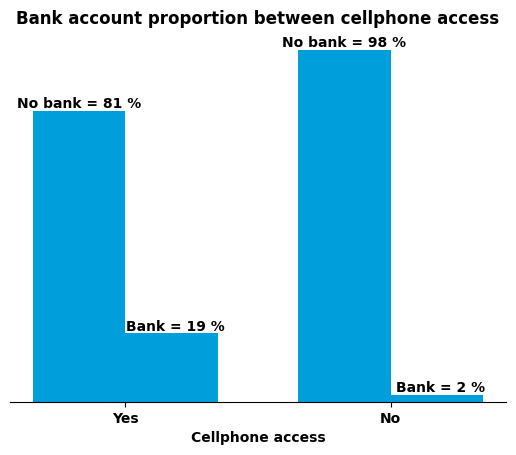

In [161]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# # Sample data
# categories = ['Yes', 'No']
# levels = ['Bank Yes', 'Bank No']
# proportions = np.random.rand(2, 2)  # Replace with your actual data

# #cellphone_props = pd.crosstab(ctdf.cellphone_access, ctdf_y, normalize="index")

# # Plot grouped bar chart
# x = np.arange(len(categories))
# width = 0.35

# fig, ax = plt.subplots()
# bars1 = ax.bar(x - width/2, [81,98], width, label='Bank No',color = "#009EDB")
# bars2 = ax.bar(x + width/2, [19,2], width, label='Bank Yes', color = "#009EDB")

# # Add labels, title, and legend

# ax.set_xlabel('Cellphone access',weight ="bold")
# ax.set_title('Bank account proportion between cellphone access', weight ="bold")
# ax.set_xticks(x)
# ax.set_xticklabels(categories, weight ="bold")
# plt.gca().spines['left'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().yaxis.set_visible(False)

# no_text = ["No bank = 81 %", "No bank = 98 %"]
# for i,bar in enumerate(bars1):
#     height = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, no_text[i], ha='center', va='bottom', weight="bold")

# yes_text = ["Bank = 19 %", "Bank = 2 %"]
# for i,bar in enumerate(bars2):
#     height = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/ 2+0.015, height + 0.01, yes_text[i], ha='center', va='bottom', weight="bold")
# # Show the plot
# plt.show()

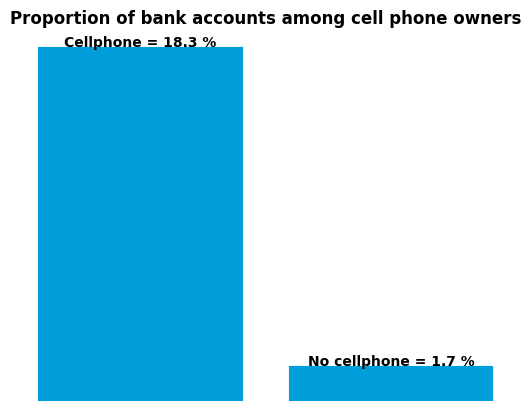

In [166]:
# # value_counts = df['bank_account'].value_counts(normalize=True)
# # value_counts = value_counts.sort_values(ascending=False)
# # bars = plt.bar(value_counts.index, value_counts.values, color = ["#009EDB", "white"], edgecolor = ["#009EDB", "#009EDB"], linewidth = 3)
# # plt.xlabel('')
# # plt.ylabel('')
# # plt.title('Bank Account', weight="bold")
# # plt.axis("off")
# # plt.xticks(rotation=90)  # Rotate x-axis labels if needed
# # ax = plt.gca()
# # ax.spines['bottom'].set_visible(False)
# # ax.spines['left'].set_visible(False)
# # ax.spines['right'].set_visible(False)

# # text = ["Yes = 86 %", "No = 14 %"]

# # for i,bar in enumerate(bars):
# #     height = bar.get_height()
# #     plt.text(bar.get_x() + bar.get_width() / 2, height+0.01, text[i], ha='center', va='bottom', weight="bold")


# # plt.show()


# value_counts = df['bank_account'].value_counts(normalize=True)
# value_counts = value_counts.sort_values(ascending=False)
# bars = plt.bar([0,1], [18.3,1.7], color = ["#009EDB", "#009EDB"], edgecolor = ["#009EDB", "#009EDB"], linewidth = 3)
# plt.xlabel('')
# plt.ylabel('')
# plt.title('Proportion of bank accounts among cell phone owners', weight="bold")
# plt.axis("off")
# plt.xticks(rotation=90)  # Rotate x-axis labels if needed
# ax = plt.gca()
# # ax.spines['bottom'].set_visible(False)
# # ax.spines['left'].set_visible(False)
# # ax.spines['right'].set_visible(False)



# text = ["Cellphone = 18.3 %", "No cellphone = 1.7 %"]
# for i,bar in enumerate(bars):
#     height = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width() / 2, height + 0.015, text[i], ha='center', va='bottom', weight="bold")

# plt.show()

In [168]:
cellphone_props = pd.crosstab(ctdf.cellphone_access,ctdf_y, normalize="index")
cellphone_props

bank_account,No,Yes
cellphone_access,,
No,0.982867,0.017133
Yes,0.816203,0.183797


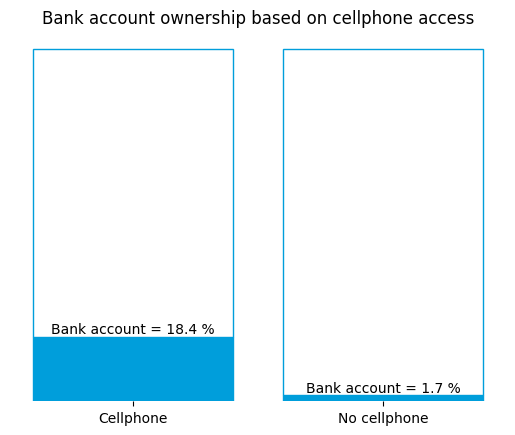

In [197]:
categories = ['Cellphone', 'No cellphone']  # X labels
labels = ['Bank account', 'No bank account']  # Not relavant? 

# Create stacked bar chart
bottombars = plt.bar(categories, [18.4, 1.7], label=labels[0], color = "#009EDB",edgecolor = "#009EDB")        # Bottom bars
plt.bar(categories, [81.6,98.3], label=labels[1], bottom=[18.4, 1.7], color ="white", edgecolor = "#009EDB")    # Top bars, bottom defines where they start,

plt.title('Bank account ownership based on cellphone access')


#ax.set_xlabel('Cellphone access',weight ="bold") # xlabel
#ax.set_xticks(x)
ax.set_xticklabels(categories, weight ="bold")     #x label
plt.gca().spines['left'].set_visible(False)         # getting rid of axis lines and box
plt.gca().spines['right'].set_visible(False)        # getting rid of axis lines and box
plt.gca().spines['top'].set_visible(False)          # getting rid of axis lines and box
plt.gca().spines['bottom'].set_visible(False)       # getting rid of axis lines and box
plt.gca().yaxis.set_visible(False)                  # getting rid of axis lines and box
plt.tick_params(axis='x', bottom=False)             # Delete axis ticks.

#plt.subplots_adjust(bottom=0.2)  # Increase bottom value to create space below x-axis

# Position legend horizontally in the space below x-axis
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon = False, ncol=2)
#
text = ["Bank account = 18.4 %", "Bank account = 1.7 %"] # Write text in plot.
for i,bar in enumerate(bottombars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.015, text[i], ha='center', va='bottom')

plt.show()